In [1]:
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 18.1 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=5352cb379b51321aa40768e7110db6f6c5b3048fb2af8ec1fc619c2d81a68941
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8a/be/f6/123e0568433d4bfc1cb662c3cd20784d9e723b3260524bb93e
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.42.0
    Uninstalling sagemaker-2.42.0:
      Successfully uninstalled sagemaker-2.42.0


In [2]:
import pandas as pd
import numpy as np
import os
import pickle as pkl

import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter

import matplotlib.pyplot as plt

from sklearn import metrics

session = sagemaker.Session()
role = get_execution_role()

In [3]:
# Custom function to convert SageMaker scores to floats
def price_extractor(predictions):
    scores = []
    for prediction in predictions[0]:
        score = prediction
        scores.append(round(float(score[9:-1]),2))
    return pd.DataFrame(scores)

## 1. Test 1: Simple XGBoost Regression

In [4]:
# Retrieve XGBoos Image
container = get_image_uri(session.boto_region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [5]:
# Create estimator object
prefix = 'capstone-wine'

simple_xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [6]:
# Set hyperparameters
simple_xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [7]:
# Train model
train_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/train1.csv'
validation_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/validation1.csv'

s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data=validation_location, content_type='text/csv')

simple_xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-05-27 14:20:38 Starting - Starting the training job...
2021-05-27 14:20:40 Starting - Launching requested ML instances......
2021-05-27 14:21:44 Starting - Preparing the instances for training......
2021-05-27 14:23:06 Downloading - Downloading input data
2021-05-27 14:23:06 Training - Downloading the training image...
2021-05-27 14:23:38 Uploading - Uploading generated training model
2021-05-27 14:23:38 Completed - Training job completed
Arguments: train
[2021-05-27:14:23:27:INFO] Running standalone xgboost training.
[2021-05-27:14:23:27:INFO] File size need to be processed in the node: 11.14mb. Available memory size in the node: 8425.2mb
[2021-05-27:14:23:27:INFO] Determined delimiter of CSV input is ','
[14:23:27] S3DistributionType set as FullyReplicated
[14:23:27] 88314x54 matrix with 4768956 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-27:14:23:27:INFO] Determined delimiter of CSV input is ','
[14:23:27] S3DistributionType set a

In [8]:
# Create transformer object
simple_xgb_transformer = simple_xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [10]:
# Make predictions
test_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/test1.csv'

simple_xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
simple_xgb_transformer.wait()

..............................
Arguments: serve
[2021-05-27 14:34:38 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-05-27 14:34:38 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-05-27 14:34:38 +0000] [1] [INFO] Using worker: gevent
[2021-05-27 14:34:38 +0000] [21] [INFO] Booting worker with pid: 21
[2021-05-27 14:34:38 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)']. 
  monkey.patch_all(subprocess=True)
[2021-05-27

In [12]:
# Transfer predictions from S3 to notebook
data_dir = '../SageMaker/data/wine_xgb'

!aws s3 cp --recursive $simple_xgb_transformer.output_path $data_dir

download: s3://sagemaker-eu-west-2-115849693658/xgboost-2021-05-27-14-29-46-505/test1.csv.out to data/wine_xgb/test1.csv.out


In [20]:
inputs_data_dir = '../SageMaker/data/wine'

# Create dataframes of predictions and actuals for comparision
Y_pred = pd.read_csv(os.path.join(data_dir, 'test1.csv.out'), header=None)
Y_test = pd.read_csv(os.path.join(inputs_data_dir, 'test1_labels.csv'), header=None)

Text(0.5, 1.0, 'Actual Price vs Predicted Price')

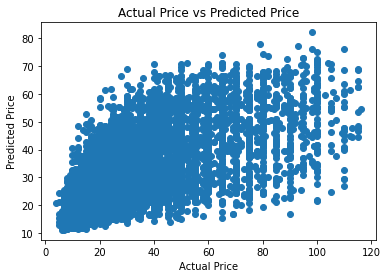

In [23]:
# Plot regression
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price")

In [24]:
# RMSE
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

14.922879965188674

In [25]:
# R2
metrics.r2_score(Y_test, Y_pred)

0.4509764993258103

In [8]:
model_file_path = 'https://sagemaker-eu-west-2-115849693658.s3.eu-west-2.amazonaws.com/capstone-wine/output/xgboost-2021-05-27-14-20-38-716/output/model.tar.gz'
bst = pkl.load(open(model_file_path, 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'https://sagemaker-eu-west-2-115849693658.s3.eu-west-2.amazonaws.com/capstone-wine/output/xgboost-2021-05-27-14-20-38-716/output/model.tar.gz'

## 2. Test 2

In this test we've replaced country with region_1 and added vintage

In [4]:
# Retrieve XGBoos Image
container = get_image_uri(session.boto_region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [5]:
# Create estimator object
prefix = 'capstone-wine'

xgb2 = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [6]:
# Set hyperparameters
xgb2.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [7]:
# Train model
train_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/train2.csv'
validation_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/validation2.csv'

s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data=validation_location, content_type='text/csv')

xgb2.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-05-28 09:42:19 Starting - Starting the training job...
2021-05-28 09:42:21 Starting - Launching requested ML instances......
2021-05-28 09:43:41 Starting - Preparing the instances for training......
2021-05-28 09:44:47 Downloading - Downloading input data...
2021-05-28 09:45:02 Training - Downloading the training image..Arguments: train
[2021-05-28:09:45:24:INFO] Running standalone xgboost training.
[2021-05-28:09:45:24:INFO] File size need to be processed in the node: 33.23mb. Available memory size in the node: 8412.0mb
[2021-05-28:09:45:24:INFO] Determined delimiter of CSV input is ','
[09:45:24] S3DistributionType set as FullyReplicated
[09:45:25] 88301x172 matrix with 15187772 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-28:09:45:25:INFO] Determined delimiter of CSV input is ','
[09:45:25] S3DistributionType set as FullyReplicated
[09:45:25] 9848x172 matrix with 1693856 entries loaded from /opt/ml/input/data/validation?format=csv&


2021-05-28 09:45:47 Uploading - Uploading generated training model
2021-05-28 09:45:47 Completed - Training job completed
[09:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[38]#011train-rmse:13.9987#011validation-rmse:15.6682
[09:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[39]#011train-rmse:13.989#011validation-rmse:15.6601
[09:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[40]#011train-rmse:13.9718#011validation-rmse:15.647
Stopping. Best iteration:
[30]#011train-rmse:14.1209#011validation-rmse:15.5289

Training seconds: 60
Billable seconds: 60


In [ ]:
# Create transformer object
xgb2_transformer = xgb2.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [ ]:
# Make predictions
test_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/test2.csv'

xgb2_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb2_transformer.wait()

......................Arguments: serve
[2021-05-28 09:59:17 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-05-28 09:59:17 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-05-28 09:59:17 +0000] [1] [INFO] Using worker: gevent
[2021-05-28 09:59:17 +0000] [20] [INFO] Booting worker with pid: 20
[2021-05-28 09:59:17 +0000] [21] [INFO] Booting worker with pid: 21
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)']. 
  monkey.patch_all(subprocess=True)
[2021-05-28:09:59:18

In [ ]:
# Transfer predictions from S3 to notebook
data_dir = '../SageMaker/data/wine_xgb'

!aws s3 cp --recursive $xgb2_transformer.output_path $data_dir

download: s3://sagemaker-eu-west-2-115849693658/xgboost-2021-05-28-09-54-03-666/test2.csv.out to data/wine_xgb/test2.csv.out


In [14]:
inputs_data_dir = '../SageMaker/data/wine'

# Create dataframes of predictions and actuals for comparision
Y_pred = pd.read_csv(os.path.join(data_dir, 'test2.csv.out'), header=None)
Y_test = pd.read_csv(os.path.join(inputs_data_dir, 'test2_labels.csv'), header=None)

Text(0.5, 1.0, 'Actual Price vs Predicted Price')

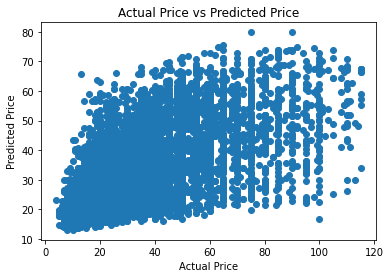

In [15]:
# Plot regression
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price")

In [16]:
# RMSE
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

14.93429315557104

In [17]:
# R2
metrics.r2_score(Y_test, Y_pred)

0.43670226797363243

## Test 3

In [18]:
# Retrieve XGBoos Image
container = get_image_uri(session.boto_region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [19]:
# Create estimator object
prefix = 'capstone-wine'

xgb3 = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [20]:
# Set hyperparameters
xgb3.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [21]:
# Train model
train_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/train3.csv'
validation_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/validation3.csv'

s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data=validation_location, content_type='text/csv')

xgb3.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-05-28 10:10:44 Starting - Starting the training job...
2021-05-28 10:10:46 Starting - Launching requested ML instances......
2021-05-28 10:12:09 Starting - Preparing the instances for training.........
2021-05-28 10:13:34 Downloading - Downloading input data
2021-05-28 10:13:34 Training - Downloading the training image..Arguments: train
[2021-05-28:10:13:55:INFO] Running standalone xgboost training.
[2021-05-28:10:13:55:INFO] File size need to be processed in the node: 50.45mb. Available memory size in the node: 8407.68mb
[2021-05-28:10:13:55:INFO] Determined delimiter of CSV input is ','
[10:13:55] S3DistributionType set as FullyReplicated
[10:13:55] 88301x264 matrix with 23311464 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-28:10:13:55:INFO] Determined delimiter of CSV input is ','
[10:13:55] S3DistributionType set as FullyReplicated
[10:13:56] 9848x264 matrix with 2599872 entries loaded from /opt/ml/input/data/validation?format=csv


2021-05-28 10:14:28 Uploading - Uploading generated training model
2021-05-28 10:14:28 Completed - Training job completed
Training seconds: 68
Billable seconds: 68


In [22]:
# Create transformer object
xgb3_transformer = xgb3.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [23]:
# Make predictions
test_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/test3.csv'

xgb3_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb3_transformer.wait()

................................Arguments: serve
[2021-05-28 10:20:11 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-05-28 10:20:11 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-05-28 10:20:11 +0000] [1] [INFO] Using worker: gevent
[2021-05-28 10:20:11 +0000] [20] [INFO] Booting worker with pid: 20
[2021-05-28 10:20:11 +0000] [21] [INFO] Booting worker with pid: 21
[2021-05-28 10:20:11 +0000] [22] [INFO] Booting worker with pid: 22
[2021-05-28 10:20:11 +0000] [23] [INFO] Booting worker with pid: 23
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.p

In [24]:
# Transfer predictions from S3 to notebook
data_dir = '../SageMaker/data/wine_xgb'

!aws s3 cp --recursive $xgb3_transformer.output_path $data_dir

download: s3://sagemaker-eu-west-2-115849693658/xgboost-2021-05-28-10-14-57-415/test3.csv.out to data/wine_xgb/test3.csv.out


In [25]:
inputs_data_dir = '../SageMaker/data/wine'

# Create dataframes of predictions and actuals for comparision
Y_pred = pd.read_csv(os.path.join(data_dir, 'test3.csv.out'), header=None)
Y_test = pd.read_csv(os.path.join(inputs_data_dir, 'test3_labels.csv'), header=None)

Text(0.5, 1.0, 'Actual Price vs Predicted Price')

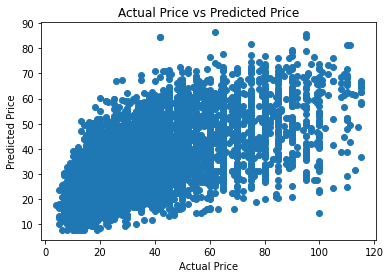

In [26]:
# Plot regression
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price")

In [27]:
# RMSE
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

14.444176634355678

In [28]:
# R2
metrics.r2_score(Y_test, Y_pred)

0.47306840509993286

## Test 4

Tune hyperparameters

In [46]:
# Retrieve XGBoos Image
container = get_image_uri(session.boto_region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [47]:
# Create estimator object
prefix = 'capstone-wine'

xgb4 = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [48]:
# Set hyperparameters
xgb4.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [49]:
# Tune hyperparameters
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb4,
                                              objective_metric_name='validation:rmse',
                                              objective_type='Minimize',
                                              max_jobs=20,
                                              max_parallel_jobs=3,
                                              hyperparameter_ranges={
                                                  'max_depth': IntegerParameter(3,12),
                                                  'eta': ContinuousParameter(0.05, 0.5),
                                                  'min_child_weight': IntegerParameter(2,8),
                                                  'subsample': ContinuousParameter(0.5, 0.9),
                                                  'gamma': ContinuousParameter(0, 10)
                                              })

In [51]:
# Train model
train_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/train3.csv'
validation_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/validation3.csv'

s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data=validation_location, content_type='text/csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
xgb_hyperparameter_tuner.wait()

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


....................................................................................................................................................................................................................................................................................................................................................................................!


In [52]:
# Print the best training job name
xgb_hyperparameter_tuner.best_training_job()

'xgboost-210603-1313-015-f80a6382'

In [53]:
# Attach estimator object to the best training job
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2021-06-03 13:35:25 Starting - Preparing the instances for training
2021-06-03 13:35:25 Downloading - Downloading input data
2021-06-03 13:35:25 Training - Training image download completed. Training in progress.
2021-06-03 13:35:25 Uploading - Uploading generated training model
2021-06-03 13:35:25 Completed - Training job completedArguments: train
[2021-06-03:13:34:12:INFO] Running standalone xgboost training.
[2021-06-03:13:34:12:INFO] Setting up HPO optimized metric to be : rmse
[2021-06-03:13:34:12:INFO] File size need to be processed in the node: 49.5mb. Available memory size in the node: 8416.0mb
[2021-06-03:13:34:12:INFO] Determined delimiter of CSV input is ','
[13:34:12] S3DistributionType set as FullyReplicated
[13:34:12] 88302x259 matrix with 22870218 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-06-03:13:34:12:INFO] Determined delimiter of CSV input is ','
[13:34:12] S3DistributionType set as FullyReplicated
[13:34:12] 9825x259 mat

In [54]:
# Create transformer object
xgb4_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [55]:
# Make predictions
test_location = 's3://sagemaker-eu-west-2-115849693658/capstone-wine/test4.csv'

xgb4_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb4_transformer.wait()

..............................
Arguments: serve
[2021-06-03 13:49:51 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-06-03 13:49:51 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-06-03 13:49:51 +0000] [1] [INFO] Using worker: gevent
[2021-06-03 13:49:51 +0000] [20] [INFO] Booting worker with pid: 20
[2021-06-03 13:49:51 +0000] [21] [INFO] Booting worker with pid: 21
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)']. 
  monkey.patch_all(subprocess=True)
[2021-06-03

In [56]:
# Transfer predictions from S3 to notebook
data_dir = '../SageMaker/data/wine_xgb'

!aws s3 cp --recursive $xgb4_transformer.output_path $data_dir

download: s3://sagemaker-eu-west-2-115849693658/xgboost-210603-1313-015-f80a6382-2021-06-03-13-45-05-458/test4.csv.out to data/wine_xgb/test4.csv.out


In [57]:
inputs_data_dir = '../SageMaker/data/wine'

# Create dataframes of predictions and actuals for comparision
Y_pred = pd.read_csv(os.path.join(data_dir, 'test4.csv.out'), header=None)
Y_test = pd.read_csv(os.path.join(inputs_data_dir, 'test4_labels.csv'), header=None)

Text(0.5, 1.0, 'Actual Price vs Predicted Price')

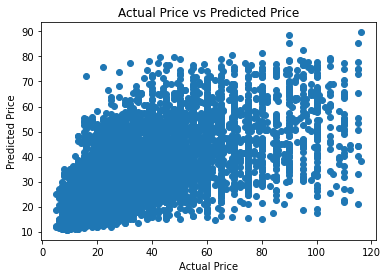

In [58]:
# Plot regression
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price")

In [59]:
# RMSE
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

14.986538657759223

In [60]:
# R2
metrics.r2_score(Y_test, Y_pred)

0.4632411975525166

## Evaluate Predictions

In [92]:
# Create data directory if it doesn't exist
data_dir = '../SageMaker/data/wine'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [93]:
# Read CSV w/ headers to perform evaluation of subset
features = pd.read_csv('data/wine/test4_header.csv')
labels = pd.read_csv('data/wine/test4_labels_header.csv')

In [94]:
features.head()

,Unnamed: 0,points,year,Argentina,Australia,Austria,Bulgaria,Canada,Chile,France,...,Sangiovese,Sauvignon Blanc,Shiraz,Sparkling Blend,Syrah,Tempranillo,Viognier,White Blend,Zinfandel,other.3
0,40023,87,2015.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,91188,85,2013.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,108721,92,2014.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,89602,87,2013.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,43373,84,2000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [95]:
# Save subset of examples to S3
prefix = 'capstone-wine'

test_features = features.sample(n=25, random_state=1)
del test_features['Unnamed: 0']
test_features.to_csv(os.path.join(data_dir, 'test4_header_eval.csv'), header=False, index=False)
test4_header_location = session.upload_data(os.path.join(data_dir, 'test4_header_eval.csv'), key_prefix=prefix)

In [96]:
# Show traits of example subset
test_features_condenced = test_features.loc[:, (test_features.sum(axis=0) != 0)]
test_features_condenced

,points,year,Argentina,Austria,Chile,France,Israel,Italy,Portugal,Spain,...,Grenache,Merlot,Pinot Grigio,Pinot Noir,Portuguese White,Red Blend,Riesling,Syrah,Tempranillo,other.3
4207,85,2007.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7789,82,2012.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1520,86,2009.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1404,88,2012.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6696,93,2011.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9457,85,2013.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10162,89,2007.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1198,94,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10062,85,2011.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9313,87,2012.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [72]:
# Attach to the best model
xgb_attached = sagemaker.estimator.Estimator.attach('xgboost-210603-1313-015-f80a6382')

# Create transformer object
xgb4_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2021-06-03 13:35:25 Starting - Preparing the instances for training
2021-06-03 13:35:25 Downloading - Downloading input data
2021-06-03 13:35:25 Training - Training image download completed. Training in progress.
2021-06-03 13:35:25 Uploading - Uploading generated training model
2021-06-03 13:35:25 Completed - Training job completed

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Arguments: train
[2021-06-03:13:34:12:INFO] Running standalone xgboost training.
[2021-06-03:13:34:12:INFO] Setting up HPO optimized metric to be : rmse
[2021-06-03:13:34:12:INFO] File size need to be processed in the node: 49.5mb. Available memory size in the node: 8416.0mb
[2021-06-03:13:34:12:INFO] Determined delimiter of CSV input is ','
[13:34:12] S3DistributionType set as FullyReplicated
[13:34:12] 88302x259 matrix with 22870218 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-06-03:13:34:12:INFO] Determined delimiter of CSV input is ','
[13:34:12] S3DistributionType set as FullyReplicated
[13:34:12] 9825x259 matrix with 2544675 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[13:34:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 6 pruned nodes, max_depth=12
[0]#011train-rmse:34.2385#011validation-rmse:35.3236
Multiple eval metrics have been passed: 'validation-rmse' will

Using already existing model: xgboost-210603-1313-015-f80a6382


In [97]:
# Run transformation
xgb4_transformer.transform(test4_header_location, content_type='text/csv', split_type='Line')
xgb4_transformer.wait()

............................Arguments: serve
[2021-06-03 14:30:04 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-06-03 14:30:04 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-06-03 14:30:04 +0000] [1] [INFO] Using worker: gevent
[2021-06-03 14:30:04 +0000] [20] [INFO] Booting worker with pid: 20
[2021-06-03 14:30:04 +0000] [21] [INFO] Booting worker with pid: 21
[2021-06-03 14:30:04 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util

In [98]:
# Transfer predictions from S3 to notebook
data_dir = '../SageMaker/data/wine_xgb'

!aws s3 cp --recursive $xgb4_transformer.output_path $data_dir

download: s3://sagemaker-eu-west-2-115849693658/xgboost-210603-1313-015-f80a6382-2021-06-03-14-25-32-144/test4_header_eval.csv.out to data/wine_xgb/test4_header_eval.csv.out


In [99]:
inputs_data_dir = '../SageMaker/data/wine'

# Create dataframes of predictions and actuals for comparision
Y_pred = pd.read_csv(os.path.join(data_dir, 'test4_header_eval.csv.out'), header=None)

In [100]:
# Import test labels
test_labels = labels.sample(n=25, random_state=1)
del test_labels['Unnamed: 0']

In [103]:
# Create dataframe comparing feature values, price, predicted price and price difference
test_features_condenced['price'] = test_labels['price']
test_features_condenced['predicted_price'] = list(Y_pred[0])
test_features_condenced['price_diff'] = test_features_condenced['price'] - test_features_condenced['predicted_price']
test_features_condenced.sort_values('price_diff', ascending=False)

/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set o

,points,year,Argentina,Austria,Chile,France,Israel,Italy,Portugal,Spain,...,Pinot Noir,Portuguese White,Red Blend,Riesling,Syrah,Tempranillo,other.3,price,predicted_price,price_diff
372,91,2003.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,84.0,38.862869,45.137131
3728,93,2013.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,91.0,55.391724,35.608276
2131,94,2013.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,80.0,52.860313,27.139687
10162,89,2007.0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,45.0,27.096924,17.903076
10062,85,2011.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,40.0,23.310823,16.689177
9313,87,2012.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,36.0,24.403324,11.596676
9457,85,2013.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,26.0,15.421486,10.578514
10557,83,2012.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,35.0,25.583347,9.416653
4964,91,2012.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,43.0,36.388996,6.611004
10340,87,2013.0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,22.0,17.979639,4.020361
